# Analyzing Satellite Images

In this tutorial, you'll learn how to extract information and knowledge from satellite imagery As we briefly covered in the previous tutorial, `Bringing Images Into Your Notebooks`, satellite images are treated as multidimensional arrays where each band being a 2-D array. 

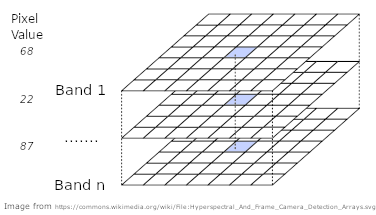

As mentioned before we are working with multi-dimensional arrays implemented in <a href="https://dask.pydata.org/en/latest" target="_blank" rel="noopener">Dask</a>, a scalable version of  <a href="http://www.numpy.org" target="_blank" rel="noopener">Numpy</a>. To do analysis using multiple bands, we use standard Numpy array functions.

## Working with Bands in Python

Let's start by pulling out single bands and giving them "names" so the math is easier to understand. 
We'll use the area of Pueblo, Colorado again, but this time we'll use imagery from the <a href="https://gbdxdocs.digitalglobe.com/docs/ikonos" target="_blank">Ikonos satellite</a> instead of Landsat. This imagery has much better spatial resolution so it will be easier to visually interpret features. 

In [ ]:
from gbdxtools import CatalogImage
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [ ]:
catalog_id = '2012052117443370000011625025'
bbox = '-104.61636543273927, 38.23971962412238, -104.58580970764162, 38.26183422148863'

#No Pan sharpening or Acomp
pueblo_image = CatalogImage(catalog_id, band_type="MS", bbox=map(float, bbox.split(",")))
pueblo_image.plot()

#Tell us the data type in the arrays
pueblo_image.dtype

In north part of the image there are baseball fields, lakes, a river, industrial areas, highways, roads, and housing. This will be a perfect image to look at how reflectance in different bands can help pull out different features (also called objects, but basically meaning "things you are interested in finding out more information on"). 

There are four bands in the multispectral image - Blue, Green, Red, and Near Infrared (NIR). NIR is the infrared region right above red in the spectrum, and turns out to have really good properties when trying to identify objects with chlorophyll in them. The IKONOS image has 11-bit pixels, which means the reflectance value for a pixel in a band will range from 0 to 2048. 

When we plot the images below we will start using the Red, Green, Blue bands to create a "normal" image. Then we are going to create a "false color" composite which show NIR reflectance as red, RED reflectance as green, and green reflectance as blue. This will make the vegetation really clear - look at the nice healthy vegetation in the baseball outfield.

#### IMPORTANT Note on Data Types
It's important to output the data type of the arrays for the image. *Uint16* stands for *unsigned integer 16 bits*, which is critical later when we do analysis. For those of you new to programming, in many languages division may not act as you expect. If x and y are integers then division:

\begin{equation*}
\frac{x}{y} = integer
\end{equation*}

will result in an integer, which is fine if there is no remainder. But if the answer is a floating point number, the programming language will usually *round* or *floor* the answer to an integer. This behavior is particularly problematic if you are calculating an index that is supposed to scale between -1 and 1 since everything may round to either -1,0, or 1, and nothing in between. 

To fix this you need to make either x or y (or both) a *floating point* number and then the programming language will produce a floating point response. Since we know we are going to do analysis with our images the first thing we need to do is make our bands floating point arrays. 

Let's pull out those bands, and then look at them with a grayscale image for each band.

In [ ]:
p_blue = pueblo_image[0,:,:].astype(np.float32)
p_green = pueblo_image[1,:,:].astype(np.float32)
p_red = pueblo_image[2,:,:].astype(np.float32)
p_nir = pueblo_image[3,:,:].astype(np.float32)

#In non-teaching code you would probably want this to be encapsualted into a function that
#just allowed you to pass in an arry of images or maybe a dict
fig = plt.figure(figsize=(20,20))

#plot the color image
a = fig.add_subplot(3,2,1)
a.axis('off')
a.set_title('R, G, B')
imgplot = plt.imshow(pueblo_image.rgb(bands=[2,1,0]))

#plot the near infrared band with red and green
a = fig.add_subplot(3,2,2)
a.axis('off')
a.set_title('NIR, R, G')
imgplot = plt.imshow(pueblo_image.rgb(bands=[3,2,1]))

#plot the blue band
a = fig.add_subplot(3,2,3)
a.axis('off')
a.set_title('blue')
#use a greyscale color ramp to show reflectance
imgplot = plt.imshow(p_blue, cmap="Greys_r")

#plot the green band
a = fig.add_subplot(3,2,4)
a.axis('off')
a.set_title('green')
imgplot = plt.imshow(p_green, cmap="Greys_r")

a = fig.add_subplot(3,2,5)
a.axis('off')
a.set_title('red')
imgplot = plt.imshow(p_red, cmap="Greys_r")

#plot the NIR band
a = fig.add_subplot(3,2,6)
a.axis('off')
a.set_title('NIR')
imgplot = plt.imshow(p_nir, cmap="Greys_r")



In Python, we can extract bands using <a href="https://www.oreilly.com/learning/how-do-i-use-the-slice-notation-in-python" target="_blank" rel="noopener">slice notation</a> on the  multidimensional array. For the blue bands, we are basically taking the first entire 2-D array from the 3-D and making it into a new 2-D array called *p_blue*.

Now with the bands, there are a few things you should notice.
1. White objects in the RGB image look bright white in all the bands except NIR. This is because white reflects back all light, hence the brightness in all bands. Our eyes can't see the infrared so it behaves differently than we expect.
2. The separate RGB bands don't look all that different, and that is to be expected. What matters more with these bands is the ratio between them.
3. The NIR band reflectance looks completely different from the RGB bands. Certain features stand out as really bright or dark. The infrared bands will be extremely helpful for distinguishing features in our images.

One type of object that really shows well in NIR is water. If you look in the south of the image, there are some small ponds that are very distinct in the NIR image but not in the RGB image. Let's use this difference as a jumping-off point for our next topic.

## Band Ratios (Remote Sensing Indices)

Much of the statistical methods for extracting information from a satellite image comes from looking at the relationship between bands. One way to think about this is that a pixel on the image is your sample unit, like a person taking an election survey. Each band from the satellite image can represent factors predicting what is in the raster cell. Following through with the analogy, each band is like different information we collect from the person taking the survey. Just like our goal would be to predict if the person will vote for a certain candidate, our goal in remote sensing is to predict what is in the cell.

In remote sensing, sometimes it's not the actual value in each band that matters. Often it is the ratio or relationship between bands. The reason the analysis works this way is because substances in the real world have a "spectral signature", which is the reflectance along different wavelengths. Here are average/idealized reflectance spectra for water, soil, and vegetation:
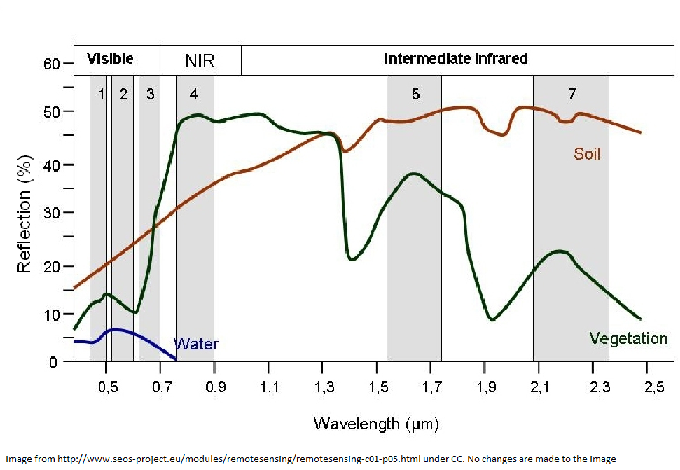

In this graphic, band 1 represents blue, 2 represents green, 3 represents red, and 4 represents NIR from our satellite bands above. You can see that soil and vegetation have about the same average reflectance in the red band, so looking at the red reflectance by itself will not help us distinguish between areas of soil and vegetation or really even water. But if we then look at NIR band, you can see that there is no reflectance for water, medium reflectance for soil, and a lot of reflection from vegetation. 

### List of Indices
Using these band characteristics, remote sensing scientists have come up with to help with feature detection. 

Since we're interested in finding water and we have access to the green and NIR bands, let's use  <a href="https://en.wikipedia.org/wiki/Normalized_difference_water_index" target="_blank" rel="noopener">McFeeters' Normalized Water Difference Index(NWDI)</a> to make water stand out. The closer the value is to 1, the stronger our belief is that the pixel represents water. There are many  <a href="https://matplotlib.org/examples/color/colormaps_reference.html" target="_blank" rel="noopener">reference colormaps</a> if you want to change the colors in the image. You can also tack an *'_r'* at the end to reverse the colormap.

In [ ]:
nwdi = ((p_green - p_nir)/(p_green + p_nir))
fig = plt.figure(figsize=(15,15))
im = plt.imshow(nwdi, cmap="bwr_r")
cbar=fig.colorbar(im,shrink=0.5)

You can see that the index pulled out the dark blue water for the lakes and the river. We also get some small ponds to become apparent at the bottom of the image. You can also pick out some of the shallows in the river near the two bridges on the east side. In the original RGB image it just looks like dark river features but here you can see there is actually some variation in the river. 

Now we have to pick an index value range for what we consider to be water. This is complicated because:
1. The bare soil and roads are also a shade of blue.
2. Some of the river water is also a lighter blue so this will complicate our range.
3. In some places the water in the lakes is lighter color as well. 

We can consider anything 0.4 or greater to be water, but where in the blue range is the lower cutoff?

### Finding Threshold Values  

Given that we are trying to pull out water bodies, in the end we are going to try and derive another raster image the same size as our image that contains only Trues and Falses (which can also be thought of as 1s and 0s respectively). Trues will represent water and Falses will be everything else. We call this a **binary mask**. In a full remote sensing study we would have field data from places on the ground that represent water and not water. We could then use this either visually or statistically to help determine our cutoff. 

Let's try a couple of thresholds at 0.2, 0.3, and 0.4 and see what we get.

In [ ]:
# Assignment in python just sets a reference NOT making a new copy. We don't need deepcopy because 
# our arrays are not compound objects
nwdipoint2 = nwdi.copy()
nwdipoint3 = nwdi.copy()
nwdipoint4 = nwdi.copy()

#Everything below 0.2 becomes a 0 and everything including 0.2 and above becomes 1
nwdipoint2 = nwdipoint2 >= 0.2

nwdipoint3 = nwdipoint3 >= 0.3

nwdipoint4 = nwdipoint4 >= 0.4

#plt.imshow(nwdipoint2, cmap='Greys')
fig = plt.figure(figsize=(20,20))
a = fig.add_subplot(2,2,1)
a.axis('off')
a.set_title('NWDI')
imgplot = plt.imshow(nwdi, cmap="bwr_r")
a = fig.add_subplot(2,2,2)
a.axis('off')
a.set_title('0.2 Threshold')
imgplot = plt.imshow(nwdipoint2, cmap="Greys_r")
a = fig.add_subplot(2,2,3)
a.axis('off')
a.set_title('0.3 Threshold')
imgplot = plt.imshow(nwdipoint3, cmap="Greys_r")
a = fig.add_subplot(2,2,4)
a.axis('off')
a.set_title('0.4 Threshold')
imgplot = plt.imshow(nwdipoint4, cmap="Greys_r")


While the 0.2 threshold does a great job of catching the river that flows into the lake and the shallow parts of the larger river, it also appears to over-identify lakes in the southern industrial area. For now we will go with 0.3 but if this was a real study we would do more fine tuning of the threshold and probably even try to mask out large chunks of the industrial areas. To get a better delineation, we could also try to get access to an image with Short-Wave Infrared (SWIR) bands, like Worldview03 or Landsat8, since that has been shown to produce <a href="http://www.ingentaconnect.com/content/asprs/pers/2009/00000075/00000011/art00004" target="_blank" rel="noopener">better delineation</a>.

## Using a Mask

Now that we have a True/False mask, we can do a little bit of band math to check the results. We are going to make the "True" pixels (NWDI >= 0.3) blue on the original image.

In [ ]:
# Peublo image is the orginal satellite image
rgb = pueblo_image.rgb(bands=[2,1,0])

# Set all the pixels in the image that had a True for 0.3 to blue
# To make blue we set the blue band to 255 (max) and the other two bands to 0
rgb[:,:,2][nwdipoint3] = [255]

fig = plt.figure(figsize=(20,20))
imgplot = plt.imshow(rgb)
plt.show()

In this tutorial, we have barely scratched the surface of image manipulations. To get a better understanding you can dig further into <a href="http://www.numpy.org" target="_blank" rel="noopener">Numpy</a> since all the images are really NumPy arrays underneath. The scikit-image library has a  <a href="http://scikit-image.org/docs/stable/user_guide/numpy_images.html" target="_blank" rel="noopener">great crash course</a> on NumPy for images. Scikit-image also has higher-order functions to do image manipulation without always having to work directly on the arrays. Another image library in Python for working with images is 
 <a href="https://pillow.readthedocs.io/en/5.1.x/index.html" target="_blank" rel="noopener">Pillow</a>, but it is considered less oriented to scientific computing. We recommend that you take a look at both and keep them in your back pocket for when you might want higher level functions than raw array manipulation. 

